# Perceptron Model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import imageio  # Import the imageio library

# Step 1: Generate a synthetic dataset
#X, y = make_circles(n_samples=200, factor=0.5, noise=0.1, random_state=42)
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Step 2: Define the Polynomial Kernel Function using the intensity profile
comblines = 6
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        # Initialize k as a trainable parameter with the same size as C
        self.k = nn.Parameter(torch.randn(comblines, dtype=torch.float, device='cpu'))

    def forward(self, C, z=2):
        return self.compute_intensity(self.k, C, z)

    def compute_intensity(self, phases, coefficients, z):
        N = coefficients.size(1)

        # Prepend NaN to coefficients and phases
        nan_tensor = torch.full((coefficients.size(0), 1), float('nan'), dtype=coefficients.dtype, device=coefficients.device)
        C = torch.cat((nan_tensor, coefficients), dim=1)

        k = torch.cat((torch.tensor([float('nan')], dtype=phases.dtype, device=phases.device), phases))

        # Preallocate intensity tensor
        intensity = torch.zeros((coefficients.size(0), 2 * N + 1), dtype=torch.float, device=C.device)

        # Use vectorized operations where possible
        m_range = [torch.full((N-1, N-1), i, device=C.device) for i in torch.arange(2, 2 * N + 1)]
        # Separate odd and even tensors based on the integer value inside the tensor
        odd_m = [m for m in m_range if m[0, 0].item() % 2 == 1]
        even_m = [m for m in m_range if m[0, 0].item() % 2 == 0]

        js, ls = torch.meshgrid(torch.arange(1, N, device=C.device), torch.arange(1, N, device=C.device), indexing='ij')
        for m in odd_m:

            valid_indices = (0 < m - js) & (m - js <= N) & (0 < m - ls) & (m - ls <= N)

            j, l, m = js[valid_indices], ls[valid_indices], m[valid_indices]

            term = 4 * C[:, j] * C[:, m - j] * C[:, l] * C[:, m - l] * torch.exp(1j * (k[j] + k[m - j] - k[l] - k[m - l]) * z)
            intensity[:, m[0]] = term.sum(dim=1)
            #torch.cuda.memory._dump_snapshot("my_snapshot.pickle")

        for m in even_m:
            if m[0, 0] == 2 or m[0, 0] == 2 * N:
                intensity[:, m[0, 0]] = C[:, m[0, 0] // 2] ** 4
            else:
                valid_indices = (0 < m - js) & (m - js <= N) & (0 < m - ls) & (m - ls <= N)

                j, l, m = js[valid_indices], ls[valid_indices], m[valid_indices]

                exp_term = torch.exp(1j * (k[j] + k[m - j]) * z)
                middle_term = C[:, m // 2] ** 2 * torch.exp(1j * 2 * k[m // 2] * z)

                term1 = (2 * C[:, j] * C[:, m - j] * exp_term + middle_term).sum(dim=1)
                term2 = (2 * C[:, l] * C[:, m - l] * exp_term.conj() + middle_term.conj()).sum(dim=1)

                intensity[:, m[0]] = (term1 * term2).real

        return torch.abs(intensity[:, 2:2 * N + 1])



In [30]:
# Original input dimension
input_dim = X_train.size(1)

# Desired higher dimension (replace with your desired value)
hidden_dim = comblines  # e.g., hidden_dim = 10

# Step 3: Create a Model
class ClassifierNNWithCustomLayer(nn.Module):
    def __init__(self):
        super(ClassifierNNWithCustomLayer, self).__init__()

        # Custom layer 
        self.custom_layer = CustomLayer() 
        self.alpha = nn.Parameter(torch.zeros(2*hidden_dim-1))
        self.bias = nn.Parameter(torch.zeros(1))  # Initialize the bias term

    def forward(self, x):
        # Create a tensor of 1's with the same batch size as x, but with one additional dimension
        ones = torch.ones(x.size(0), 1)  # Shape: (batch_size, 1)
        # Concatenate the ones at the beginning of the input tensor along dimension 1
        x = torch.cat((ones, ones, x, ones, ones), dim=1)  # Concatenate [1, x_1, y_1, 1]
        x = self.custom_layer(x)  # Apply the custom layer
        x = torch.matmul(x, self.alpha)+self.bias
        return x

# Step 4: Train the Model and Visualize
model = ClassifierNNWithCustomLayer()
optimizer = optim.Adam([model.custom_layer.k, model.alpha, model.bias], lr=0.02)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits

# Convert y_train to have values 0 and 1 for binary classification
y_train_binary = (y_train > 0).float()

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, epoch):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict the function value for the whole grid
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = torch.sigmoid(Z)
        Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title(f'Epoch {epoch}')
    plt.savefig(f'./Boundary_Physical_Kernel_images/plot_epoch_{epoch}.png')  # Save the figure
    plt.close()

interval_images = 1

# Training loop with visualization
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train_binary)
    loss.backward()
    optimizer.step()

    # Plot the decision boundary every 100 epochs
    if (epoch + 1) % interval_images  == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        plot_decision_boundary(X_train.numpy(), y_train.numpy(), model, epoch+1)


# Convert saved images to a GIF
images = []
for epoch in range(1, epochs+1):
    if (epoch) % interval_images  == 0:
        images.append(imageio.imread(f'./Boundary_Physical_Kernel_images/plot_epoch_{epoch}.png'))
imageio.mimsave('./Boundary_Physical_Kernel_images/decision_boundary_evolution.gif', images, fps=5)

# Final evaluation on test data
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = torch.sigmoid(y_pred)
    y_pred_class = (y_pred > 0.5).float()

# Convert back to NumPy for scikit-learn metrics
y_pred_class = y_pred_class.numpy()
y_test = y_test.numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')


Epoch [1/100], Loss: 0.6931
Epoch [2/100], Loss: 9.8430
Epoch [3/100], Loss: 5.5938
Epoch [4/100], Loss: 1.6411
Epoch [5/100], Loss: 2.4689
Epoch [6/100], Loss: 3.5072
Epoch [7/100], Loss: 3.3980
Epoch [8/100], Loss: 2.7037
Epoch [9/100], Loss: 1.9035
Epoch [10/100], Loss: 1.3142
Epoch [11/100], Loss: 1.1005
Epoch [12/100], Loss: 1.3385
Epoch [13/100], Loss: 1.7462
Epoch [14/100], Loss: 1.6377
Epoch [15/100], Loss: 1.2298
Epoch [16/100], Loss: 0.8843
Epoch [17/100], Loss: 0.7702
Epoch [18/100], Loss: 0.8052
Epoch [19/100], Loss: 0.8694
Epoch [20/100], Loss: 0.8721
Epoch [21/100], Loss: 0.7783
Epoch [22/100], Loss: 0.6122
Epoch [23/100], Loss: 0.4566
Epoch [24/100], Loss: 0.4199
Epoch [25/100], Loss: 0.4761
Epoch [26/100], Loss: 0.4688
Epoch [27/100], Loss: 0.3759
Epoch [28/100], Loss: 0.8820
Epoch [29/100], Loss: 0.4431
Epoch [30/100], Loss: 0.6617
Epoch [31/100], Loss: 0.7165
Epoch [32/100], Loss: 0.6716
Epoch [33/100], Loss: 0.6599
Epoch [34/100], Loss: 0.7400
Epoch [35/100], Loss: 0

C:\Users\dalop\AppData\Local\Temp\ipykernel_8456\764500954.py:78: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'./Boundary_Physical_Kernel_images/plot_epoch_{epoch}.png'))


Accuracy: 0.9500


# Convolutional NN Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Step 1: Download the dataset

# Transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


# Step 2: Define the Custom Kernel Function using the intensity profile
class CustomLayer(nn.Module):
    def __init__(self, comblines):
        super(CustomLayer, self).__init__()
        self.comblines = comblines
        # Initialize k as a trainable parameter with the same size as C
        self.k = nn.Parameter(torch.randn(comblines, dtype=torch.float, device='cpu'))

    def forward(self, C, z=0.01):
        return self.compute_intensity(self.k, C, z)

    def compute_intensity(self, phases, coefficients, z):
        N = self.comblines

        # Prepend NaN to coefficients and phases
        nan_tensor = torch.full((coefficients.size(0), 1), 0, dtype=coefficients.dtype, device=coefficients.device)
        C = torch.cat((nan_tensor, coefficients), dim=1)

        k = torch.cat((torch.tensor([0], dtype=phases.dtype, device=phases.device), phases))

        # Preallocate intensity tensor
        intensity = torch.zeros((coefficients.size(0), 2 * N + 1), dtype=torch.float, device=C.device)

        # Use vectorized operations where possible
        m_range = [torch.full((N-1, N-1), i, device=C.device) for i in torch.arange(2, 2 * N + 1)]
        # Separate odd and even tensors based on the integer value inside the tensor
        odd_m = [m for m in m_range if m[0, 0].item() % 2 == 1]
        even_m = [m for m in m_range if m[0, 0].item() % 2 == 0]

        js, ls = torch.meshgrid(torch.arange(1, N, device=C.device), torch.arange(1, N, device=C.device), indexing='ij')
        for m in odd_m:

            valid_indices = (0 < m - js) & (m - js <= N) & (0 < m - ls) & (m - ls <= N)

            j, l, m = js[valid_indices], ls[valid_indices], m[valid_indices]

            term = 4 * C[:, j] * C[:, m - j] * C[:, l] * C[:, m - l] * torch.cos((k[j] + k[m - j] - k[l] - k[m - l]) * z)
            intensity[:, m[0]] = term.sum(dim=1)
            #torch.cuda.memory._dump_snapshot("my_snapshot.pickle")

        for m in even_m:
            if m[0, 0] == 2 or m[0, 0] == 2 * N:
                intensity[:, m[0, 0]] = C[:, m[0, 0] // 2] ** 4
            else:
                valid_indices = (0 < m - js) & (m - js <= N) & (0 < m - ls) & (m - ls <= N)

                j, l, m = js[valid_indices], ls[valid_indices], m[valid_indices]

                exp_term = torch.exp(1j * (k[j] + k[m - j]) * z)
                middle_term = C[:, m // 2] ** 2 * torch.exp(1j * 2 * k[m // 2] * z)

                term1 = (2 * C[:, j] * C[:, m - j] * exp_term + middle_term).sum(dim=1)
                term2 = (2 * C[:, l] * C[:, m - l] * exp_term.conj() + middle_term.conj()).sum(dim=1)

                intensity[:, m[0]] = (term1 * term2).real

        return torch.abs(intensity[:, 2:2 * N + 1])/40000000



In [2]:
class CNNWithCustomLayer(nn.Module):
    def __init__(self):
        super(CNNWithCustomLayer, self).__init__()
        self.flatten_size = 96 # Adjusted size after concatenation
        self.custom_layer = CustomLayer(comblines=self.flatten_size)

        # First convolutional layer: 32 filters, 3x3 kernel, input shape is (28, 28, 1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # input channels = 1 (grayscale), output channels = 32
        # Max pooling layer: 2x2 pool size
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer 1: input size is 32 * 13 * 13 after conv + pool, output is 96
        self.fc1 = nn.Linear(32 * 13 * 13, self.flatten_size)
        # Add a Dropout layer with a dropout rate of 0.5
        self.dropout = nn.Dropout(p=0.5)     
        # Batch normalization for the fully connected layer
        self.bn1 = nn.BatchNorm1d(2*self.flatten_size-1)
        # Fully connected layer 2: output is 10 (for 10 classes)
        self.fc2 = nn.Linear(2*self.flatten_size-1, 10)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)      
        x = self.custom_layer(self.fc1(x))
        #x = self.bn1(x)
        #x = self.dropout(x)
        
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [3]:
import os


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    # Save checkpoint after each epoch (optional)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
    }
    torch.save(checkpoint, f'./checkpoints_PhysicalNN/model_checkpointM{epoch}.pth')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')


model = CNNWithCustomLayer()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


checkpoint_file = './checkpoints_PhysicalNN/model_checkpoint10.pth'

if os.path.exists(checkpoint_file):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_file)

    # Restore the model, optimizer, and epoch
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    running_loss = checkpoint['loss']

    # If using GPU, ensure the model and optimizer are on the correct device
    model.to(device)

    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

num_epochs = 10
for epoch in range(start_epoch, start_epoch + num_epochs):  # Adjust the range as needed
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

print("Finished Training")


No checkpoint found. Starting training from scratch.
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307156
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.143584
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.332575
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.188778
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.339750
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.063313
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.191926
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.199433
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.058020
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.198895
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.129073
Train Epoch: 0 [35200/60000 (59%)]	Loss: 0.038347
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.538872
Train Epoch: 0 [41600/60000 (69%)]	Loss: 0.084102
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.009199
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.038366
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.074737
Train Epoch: 0 [54400/60000 (91%)]	Loss: 0.227730
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.049853

Test 

In [ ]:
optimizer.param_groups

Predicted Class: 1


C:\Users\dalop\AppData\Local\Temp\ipykernel_35060\1435961853.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints_PhysicalNN/model_che

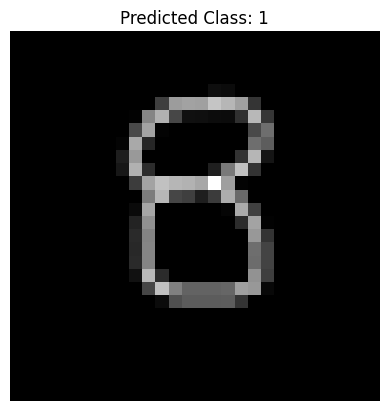

In [13]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Step 1: Load the image and preprocess it
image = Image.open('./individual_test_images/ocho.png')
image_gray = image.convert('L')
image_resized = image_gray.resize((28, 28))

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image_resized)

# Add a batch dimension (required by the model)
image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

# Step 2: Load the model and put it in evaluation mode
model = CNNWithCustomLayer()
checkpoint = torch.load('./checkpoints_PhysicalNN/model_checkpointM5.pth')  # Load the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Step 3: Forward the image through the model
with torch.no_grad():  # No need to track gradients for inference
    output = model(image_tensor)

# Step 4: Interpret the output
predicted_class = output.argmax(dim=1, keepdim=True)  # Get the predicted class index
print(f'Predicted Class: {predicted_class.item()}')

# Step 5: Visualize the image (optional)
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class.item()}')
plt.axis('off')
plt.show()

In [7]:
class CNNWithCustomLayer1(nn.Module):
    def __init__(self):
        super(CNNWithCustomLayer1, self).__init__()
        self.flatten_size = 96 # Adjusted size after concatenation
        self.custom_layer = CustomLayer(comblines=self.flatten_size)

        # First convolutional layer: 32 filters, 3x3 kernel, input shape is (28, 28, 1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  # input channels = 1 (grayscale), output channels = 32
        # Max pooling layer: 2x2 pool size
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer 1: input size is 32 * 13 * 13 after conv + pool, output is 96
        self.fc1 = nn.Linear(32 * 13 * 13, self.flatten_size)
        # Add a Dropout layer with a dropout rate of 0.5
        self.dropout = nn.Dropout(p=0.5)     
        # Batch normalization for the fully connected layer
        self.bn1 = nn.BatchNorm1d(self.flatten_size)
        # Fully connected layer 2: output is 10 (for 10 classes)
        self.fc2 = nn.Linear(self.flatten_size, 10)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)      
        x = F.relu(self.fc1(x))
        #x = self.bn1(x)
        #x = self.dropout(x)        
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [8]:
import os


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    # Save checkpoint after each epoch (optional)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item()
    }
    torch.save(checkpoint, f'./checkpoints_PhysicalNN/model_checkpointM{epoch}.pth')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)\n')


model = CNNWithCustomLayer1()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


checkpoint_file = './checkpoints_PhysicalNN/model_checkpoint10.pth'

if os.path.exists(checkpoint_file):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_file)

    # Restore the model, optimizer, and epoch
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    running_loss = checkpoint['loss']

    # If using GPU, ensure the model and optimizer are on the correct device
    model.to(device)

    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch + 1}")
else:
    print("No checkpoint found. Starting training from scratch.")
    start_epoch = 0

num_epochs = 10
for epoch in range(start_epoch, start_epoch + num_epochs):  # Adjust the range as needed
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

print("Finished Training")


No checkpoint found. Starting training from scratch.
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.526127
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.481292
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.227462
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.288296
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.202665
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.155661
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.338388
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.068519
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.046081
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.155011
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.153032
Train Epoch: 0 [35200/60000 (59%)]	Loss: 0.045591
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.056686
Train Epoch: 0 [41600/60000 (69%)]	Loss: 0.072837
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.033080
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.107930
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.095552
Train Epoch: 0 [54400/60000 (91%)]	Loss: 0.278568
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.282051

Test 

Predicted Class: 1


C:\Users\dalop\AppData\Local\Temp\ipykernel_9048\1907311431.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints_PhysicalNN/model_chec

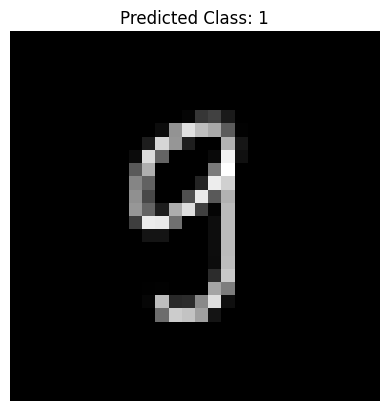

In [10]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Step 1: Load the image and preprocess it
image = Image.open('./individual_test_images/seisd.png')
image_gray = image.convert('L')
image_resized = image_gray.resize((28, 28))

# Convert the image to a PyTorch tensor
transform = transforms.ToTensor()
image_tensor = transform(image_resized)

# Add a batch dimension (required by the model)
image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, 1, 28, 28]

# Step 2: Load the model and put it in evaluation mode
model = CNNWithCustomLayer1()
checkpoint = torch.load('./checkpoints_PhysicalNN/model_checkpointM9.pth')  # Load the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Step 3: Forward the image through the model
with torch.no_grad():  # No need to track gradients for inference
    output = model(image_tensor)

# Step 4: Interpret the output
predicted_class = output.argmax(dim=1, keepdim=True)  # Get the predicted class index
print(f'Predicted Class: {predicted_class.item()}')

# Step 5: Visualize the image (optional)
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title(f'Predicted Class: {predicted_class.item()}')
plt.axis('off')
plt.show()